In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

***
# 0

Importar los datos a un Notebook y mostrarlos usando pandas. Graficar las dos tablas de datos, puesto que necesitamos identificar y eliminar algunos datos. Guarde la gráfica en formato png.+5


In [2]:
incident = pd.read_table("incident_angle_030347.txt",skiprows=1)
refracted = pd.read_table("refraction_trans_ang_030333.txt",skiprows=1)

incident = incident.set_index("t").rename(columns={"θ":"incident"})
refracted = refracted.set_index("t").rename(columns={"θ":"refracted"})

data = pd.concat([incident,refracted],axis=1)

In [3]:
data.head()

,incident,refracted
t,,
0.0000,170.279427,0.0
0.1001,168.282275,0.0
0.2002,168.630136,0.0
0.3003,167.099544,0.0
0.4004,164.158466,0.0


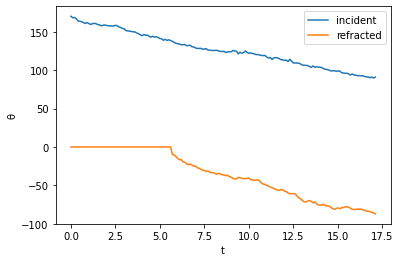

In [4]:
data.plot()
plt.ylabel("θ")
plt.savefig("datos.png",dpi=200)

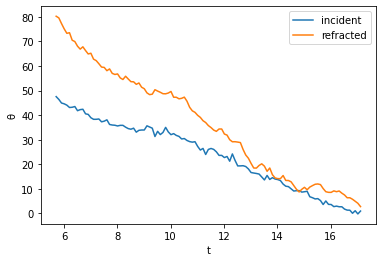

In [5]:
# delete zero data from the beginning of refracted data
data = data[data.refracted != 0]
# correct zero point of the angles
data.refracted += 90
data.incident -= 90

data.plot()
plt.ylabel("θ")
plt.savefig("datos_corregidos.png",dpi=200)

***
# 1

Crear un archivo .py con tres funciones, una quecalcule la pendiente, otra que calcule el punto decorte, otra que calcule el coeficiente de correlación,todo para un ajuste lineal por mínimos cuadrados.+30

In [6]:
with open("functions.py","w") as file:
    file.write("""
from scipy.stats import linregress    

def slope(x,y):
    return linregress(x,y).slope
def intercept(x,y):
    return linregress(x,y).intercept
def corr_coef(x,y):
    return linregress(x,y).rvalue
""")

***
# 3

Importe el archivo al Notebook y realice un ajuste por mínimos cuadrados a los datos obtenidos. +10.

In [7]:
%run functions.py

In [8]:
def report_regression(x,y):
    return f"y = (m={slope(x,y):.2f}) * x + (b={intercept(x,y):.2f}) with R^2={corr_coef(x,y):.4f}"

In [9]:
sin_data = np.sin(np.deg2rad(data))
sin_data.rename(columns=lambda s: f"sin({s})",inplace=True)
sin_data.head()

,sin(incident),sin(refracted)
t,,
5.706067,0.737749,0.985518
5.806167,0.724215,0.983433
5.906267,0.706350,0.975364
6.006367,0.702301,0.966411
6.106467,0.695602,0.957795


In [10]:
print(report_regression(*sin_data.values.T))

y = (m=1.34) * x + (b=0.02) with R^2=0.9895


Grafique los datos y el ajuste realizado, guarde la gráfica en formato png.+10

In [11]:
def regression_function(x,y):
    return np.poly1d(np.polyfit(x,y,deg=1))

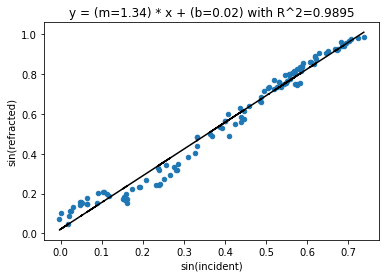

In [21]:
x,y = sin_data.values.T
f = regression_function(x,y)

sin_data.plot(kind="scatter",x="sin(incident)",y="sin(refracted)")
plt.plot(x,f(x),c='k')

plt.title(report_regression(x,y))
plt.savefig("regresion_indice.png",dpi=200)

Concluya, de acuerdo al ajuste realizado indique cuál es el índice de refracción obtenido. Por favor incluya la frase: El índice de refracción obtenido es n= ". +5

In [13]:
print(f"El índice de refracción obtenido es n={slope(x,y)}") 

El índice de refracción obtenido es n=1.3398208993672327


Realice el mismo procedimiento utilizando las fórmulas matriciales (+10) y por scikit learn (+10), imprima la fórmula de regresión obtenida (+10) y compare con los resultados en los puntos anteriores(+10). +40

In [14]:
x,y = sin_data.values.T

### forma matricial:

In [15]:
A = np.vander(x,2)
matrix_slope,matrix_intercept = np.linalg.pinv(A) @ y
matrix_Rsq = 1 - sum((y-matrix_slope*x-matrix_intercept)**2) / sum((y-y.mean())**2)
print(f"El índice de refracción obtenido es n={matrix_slope}")
print(f"El intercepto es {matrix_intercept} y el coeficiente de correlación es {matrix_Rsq}")

El índice de refracción obtenido es n=1.339820899367233
El intercepto es 0.02142904797210562 y el coeficiente de correlación es 0.9790232118536255


### scikit learn:

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
reg = LinearRegression().fit(x[:,None], y)
sk_slope = reg.coef_[0]
sk_intercept = reg.intercept_
sk_Rsq = reg.score(x[:,None], y)
print(f"El índice de refracción obtenido es n={sk_slope}")
print(f"El intercepto es {sk_intercept} y el coeficiente de correlación es {sk_Rsq}")

El índice de refracción obtenido es n=1.3398208993672327
El intercepto es 0.021429047972105653 y el coeficiente de correlación es 0.9790232118536255


### Conclusión:

los tres métodos producen resultados similares hasta casi el último decimal de precisión, lo que probablemente sea causado por el error numérico a la hora de hacer las operaciones, y no significa que los métodos produzcan resultados significativamente distintos:

In [18]:
np.diff([
    slope(x,y),
    sk_slope,
    matrix_slope,
    slope(x,y) # added for circularity
])

array([ 0.00000000e+00,  2.22044605e-16, -2.22044605e-16])

Todos esos resultados difieren en muchísimo menos que lo que reporta scipy como el error en la pendiente:

In [19]:
linregress(x,y).stderr

0.018449326974633407

Lo mismo sucede con el intercepto:

In [20]:
linregress(x,y).intercept_stderr

0.008264944371214687